In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py, json

from scipy import stats
from sessions import *
from session.adapters import H5NAMES

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = selected_013608
#sessions = selected_013829
#sessions = selected_009265
    
sessions

['013608_ppcSIT_2025-01-06_13-20-52',
 '013608_ppcSIT_2025-01-07_08-47-27',
 '013608_ppcSIT_2025-01-07_15-38-23',
 '013608_ppcSIT_2025-01-09_09-09-55',
 '013608_ppcSIT_2025-01-10_09-25-04',
 '013608_ppcSIT_2025-01-13_14-01-40',
 '013608_ppcSIT_2025-01-14_10-20-14',
 '013608_ppcSIT_2025-01-15_14-56-18',
 '013608_ppcSIT_2025-01-16_09-49-21',
 '013608_ppcSIT_2025-01-17_10-07-00',
 '013608_ppcSIT_2025-01-20_09-38-20',
 '013608_ppcSIT_2025-01-21_08-50-02',
 '013608_ppcSIT_2025-01-22_12-59-00',
 '013608_ppcSIT_2025-01-23_08-46-51',
 '013608_ppcSIT_2025-01-24_08-19-45',
 '013608_ppcSIT_2025-01-27_09-00-20',
 '013608_ppcSIT_2025-01-29_12-34-08',
 '013608_ppcSIT_2025-02-18_14-15-52',
 '013608_ppcSIT_2025-02-19_13-50-59',
 '013608_ppcSIT_2025-02-27_08-56-52',
 '013608_ppcSIT_2025-02-28_16-23-29',
 '013608_ppcSIT_2025-03-03_08-55-30',
 '013608_ppcSIT_2025-03-04_09-17-16',
 '013608_ppcSIT_2025-03-05_10-33-41']

In [5]:
# collecting unit numbers
# for 57: 9 shanks
shank_count = 4
s_names = ['units', 'descendants', 'AEPs', 'bMAPs', 'nMAPs', 'nMAP_seg']
f_names = ['units.h5', 'descendants.h5', 'AEPs.h5', 'analysis/MoSeq_tSNE_UMAP.h5', \
           'analysis/W1-W4_tSNE_UMAP.h5', 'analysis/nMAP_segmentation.h5']

unit_mx = np.zeros([len(sessions), shank_count], dtype=np.int16)
performance = np.zeros(len(sessions))
tgt_freqs   = np.zeros(len(sessions))
tgt_durs    = np.zeros(len(sessions))
file_status = np.zeros([len(sessions), len(s_names)])

for i, session in enumerate(sessions):
    animal      = session.split('_')[0]
    meta_file   = os.path.join(source, animal, session, 'meta.h5')
    units_file  = os.path.join(source, animal, session, 'units.h5')

    # performance and target freq / duration
    with h5py.File(meta_file, 'r') as f:
        trials = np.array(f['processed']['trial_idxs'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_freqs[i] = cfg['sound']['sounds']['background']['freq']
    tgt_durs[i]  = cfg['sound']['sounds']['target']['duration']
        
    tr_succ = trials[trials[:, 5] == 1]
    performance[i] = len(tr_succ) / (len(trials))
    
    for j, name in enumerate(f_names):
        if os.path.exists(os.path.join(source, animal, session, name)):
            file_status[i][j] = 1
    
    if file_status[i][0] == 0:
        print("Session %s - no units" % session)
        continue

    # unit count        
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]

    shanks = np.unique([int(x[0]) for x in unit_names])
    shanks.sort()
    
    for shank in shanks:
        unit_mx[i, shank - 1] = len([x for x in unit_names if int(x[0]) == shank])

In [6]:
# detected shanks
shanks#, el_shank_names

array([1, 2, 3, 4])

In [7]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame()
#df['session'] = [s[-19:-6] for s in sessions]
df['session'] = sessions

el_shank_names = [el for el in range(unit_mx.shape[1])]
for i in el_shank_names:
    df[str(i + 1)] = unit_mx[:, i]
    
# dual implants
#df['A1'] = df[[str(i+1) for i in el_shank_names[:1]]].sum(axis=1)
#df['PPC'] = df[[str(i+1) for i in el_shank_names[1:]]].sum(axis=1)

# Neuropixels
df['Total'] = df[[str(i+1) for i in el_shank_names]].sum(axis=1)
    
df['performance'] = np.round(performance, 3)
df['frequency']   = tgt_freqs.astype(np.int16)
df['duration']    = 1000*tgt_durs
for i, name in enumerate(s_names):
    df[name] = file_status[:, i]

df[:50]
#df[(df['duration'] > 60) & (df['performance'] > 0.5) & (df['PPC'] > 0)]

,session,1,2,3,4,Total,performance,frequency,duration,units,descendants,AEPs,bMAPs,nMAPs,nMAP_seg
0,013608_ppcSIT_2025-01-06_13-20-52,18,23,18,14,73,0.795,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
1,013608_ppcSIT_2025-01-07_08-47-27,27,30,16,17,90,0.891,660,50.0,1.0,1.0,0.0,1.0,0.0,0.0
2,013608_ppcSIT_2025-01-07_15-38-23,49,56,54,61,220,0.714,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
3,013608_ppcSIT_2025-01-09_09-09-55,17,27,11,6,61,0.556,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
4,013608_ppcSIT_2025-01-10_09-25-04,29,19,12,9,69,0.841,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
5,013608_ppcSIT_2025-01-13_14-01-40,27,21,16,16,80,0.943,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
6,013608_ppcSIT_2025-01-14_10-20-14,36,39,42,32,149,0.902,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
7,013608_ppcSIT_2025-01-15_14-56-18,35,39,34,45,153,0.904,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
8,013608_ppcSIT_2025-01-16_09-49-21,20,14,5,11,50,0.963,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0
9,013608_ppcSIT_2025-01-17_10-07-00,22,18,6,21,67,0.981,660,50.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# 60_SIT_2023-08-31_10-48-38 - A1 - empty, PPC 3 cells, done
# 60_SIT_2023-09-06_09-48-08 - A1 - empty, PPC 4 cells, done
# 60_SIT_2023-09-24_19-04-06 - A1 worth looking, PPC ~one cell, done
# 60_SIT_2023-09-25_19-10-36 - A1 - one cell, PPC nothing, done
# 60_SIT_2023-09-26_19-10-17 - A1 a few cells, PPC a few cells, done
# 60_SIT_2023-09-28_09-55-55 - A1, PPC - something to look at, done
# 60_SIT_2023-11-18_19-12-56 - A1 - empty, PPC - a few cells, done
# 60_SIT_2023-11-24_13-17-01 - A1 - empty, PPC - 15 cells, done

In [8]:
for dur in [57.5, 75, 100, 150]:
    print(df[df['duration'] == dur]['performance'].mean())

nan
nan
nan
nan


In [8]:
df[df['duration'] == 57.5]['0'].sum()

64

## Unit to S1 correlations

In [8]:
#selected = sessions[:]

selected = [
    "60_SIT_2023-09-26_19-10-17",
    "60_SIT_2023-09-28_09-55-55"
]

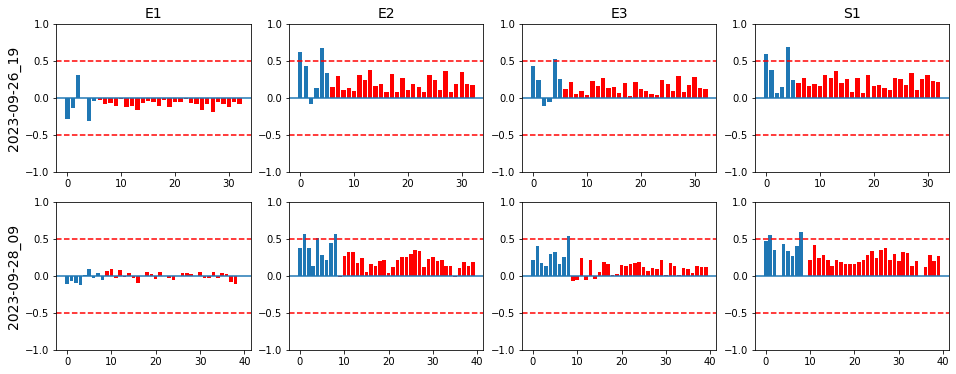

In [9]:
titles = ['E1', 'E2', 'E3', 'S1']
rows = len(selected)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, rows*3))

for i, session in enumerate(selected):
    animal     = session.split('_')[0]
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    units_file = os.path.join(source, animal, session, 'units.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        w_mx = np.array(f['w_mx'])

    # load units
    unit_names, single_units, spike_times = [], {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        
    results = np.zeros([len(unit_names), 4])
    for j, unit_name in enumerate(unit_names):
        for phase in range(4):
            i_rate_ev = single_units[unit_name][events[:, 2].astype(np.int32)]
            results[j][phase] = stats.pearsonr(i_rate_ev, w_mx[:, phase])[0]
    
    for j in range(4):
        colors = ['tab:blue' if int(unit_name[0]) < 3 else 'red' for unit_name in unit_names]
        ax = axes[i][j]
        ax.bar(np.arange(len(unit_names)), results[:, j], color=colors)
        ax.set_ylim(-1, 1)
        ax.axhline(-0.5, color='red', ls='--')
        ax.axhline(0.5, color='red', ls='--')
        ax.axhline(0)
        if i == 0:
            ax.set_title(titles[j], fontsize=14)
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)
        
    #if session == '57_SIT_2024-01-05_14-35-49':
    #    break